# Deep Dreams (with Caffe)

This notebook demonstrates how to use [Caffe](http://caffe.berkeleyvision.org/) neural network framework to produce "dream" visuals shown in the [Google Research blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

It'll be interesting to see what imagery people are able to generate using the described technique. If you post images to Google+, Facebook, or Twitter, be sure to tag them with **#deepdream** so other researchers can check them out too.

##Dependences
This notebook is designed to have as few depencences as possible:
* Standard Python scientific stack: [NumPy](http://www.numpy.org/), [SciPy](http://www.scipy.org/), [PIL](http://www.pythonware.com/products/pil/), [IPython](http://ipython.org/). Those libraries can also be installed as a part of one of scientific packages for Python, such as [Anaconda](http://continuum.io/downloads) or [Canopy](https://store.enthought.com/).
* [Caffe](http://caffe.berkeleyvision.org/) deep learning framework ([installation instructions](http://caffe.berkeleyvision.org/installation.html)).
* Google [protobuf](https://developers.google.com/protocol-buffers/) library that is used for Caffe model manipulation.

In [1]:
# imports and basic notebook setup
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

import caffe

def showarray(a, fmt='jpeg'):
   # a = np.uint8(np.clip(a, 0, 255))
    a = np.uint8(np.clip(a, 0, 250))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

## Loading DNN model
In this notebook we are going to use a [GoogLeNet](https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet) model trained on [ImageNet](http://www.image-net.org/) dataset.
Feel free to experiment with other models from Caffe [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). One particulary interesting [model](http://places.csail.mit.edu/downloadCNN.html) was trained in [MIT Places](http://places.csail.mit.edu/) dataset. It produced many visuals from the [original blog post](http://googleresearch.blogspot.ch/2015/06/inceptionism-going-deeper-into-neural.html).

In [2]:
import os
print os.getcwd()

/home/jack/Desktop/deep-dream-generator/notebooks


In [3]:
!ls /notebooks/models/jcaffe

ls: cannot access '/notebooks/models/jcaffe': No such file or directory


In [4]:
#model_path = 'models/jcaffe/' # substitute your path here
#net_fn   = model_path + 'deploy.prototxt'
#param_fn = model_path + 'jcaffe.caffemodel'

model_path = 'models/jcaffe/may16/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'may16.caffemodel'


# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

##  Producing dreams

Making the "dream" images is very simple. Essentially it is just a gradient ascent process that tries to maximize the L2 norm of activations of a particular DNN layer. Here are a few simple tricks that we found useful for getting good images:
* offset image by a random jitter
* normalize the magnitude of gradient ascent steps
* apply ascent across multiple scales (octaves)

First we implement a basic gradient ascent step function, applying the first two tricks:

In [5]:
def make_step(net, step_size=1.5, end='pool5', jitter=8, clip=True):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    dst.diff[:] = dst.data  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)    

Next we implement an ascent through different scales. We call these scales "octaves".

In [6]:
def deepdream(net, base_img, iter_n=4, octave_n=4, octave_scale=1.4, end='pool5', clip=True, **step_params):
    # The first ' Dream ' created
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

Now we are ready to let the neural network to reveal its dreams! Let's take a [cloud image](https://commons.wikimedia.org/wiki/File:Appearance_of_sky_for_weather_forecast,_Dhaka,_Bangladesh.JPG) as a starting point:

In [17]:
import os
print("Path at terminal when executing this file")
print(os.getcwd() + "\n")



Path at terminal when executing this file
/notebooks



Available image inputs: input.jpg - input10.jpg 

In [8]:
!wget https://upload.wikimedia.org/wikipedia/commons/7/75/Building_and_pond_with_line_of_stormy_clouds_above.jpg

--2017-05-24 07:08:06--  https://upload.wikimedia.org/wikipedia/commons/7/75/Building_and_pond_with_line_of_stormy_clouds_above.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360966 (353K) [image/jpeg]
Saving to: 'Building_and_pond_with_line_of_stormy_clouds_above.jpg'

Building_and_pond_w 100%[===================>] 352.51K  29.3KB/s    in 14s     

2017-05-24 07:08:23 (25.4 KB/s) - 'Building_and_pond_with_line_of_stormy_clouds_above.jpg' saved [360966/360966]



In [8]:
!ls images/*.jpg

images/0001a.jpg  images/0049.jpg  images/0090.jpg
images/0001.jpg   images/0052.jpg  images/0091.jpg
images/0002.jpg   images/0053.jpg  images/0092.jpg
images/0003.jpg   images/0054.jpg  images/0093.jpg
images/0004.jpg   images/0055.jpg  images/032.jpg
images/0005.jpg   images/0056.jpg  images/1.jpg
images/0007.jpg   images/0057.jpg  images/2.jpg
images/0008.jpg   images/0058.jpg  images/320x240.jpg
images/0009.jpg   images/0059.jpg  images/3.jpg
images/0010.jpg   images/0060.jpg  images/a001.jpg
images/0011.jpg   images/0062.jpg  images/a320x240.jpg
images/0012.jpg   images/0063.jpg  images/ajungle.jpg
images/0014.jpg   images/0064.jpg  images/amarket.jpg
images/0015.jpg   images/0066.jpg  images/ariver002.jpg
images/0016.jpg   images/0068.jpg  images/ariver.jpg
images/0018.jpg   images/0070.jpg  images/awaterfall.jpg
images/0021.jpg   images/0071.jpg  images/d-0020.png.jpg
images/0025.jpg   images/0072.jpg  images/dream-bordered.jpg
images/0026.jpg   images/0073.jpg  images/elephant

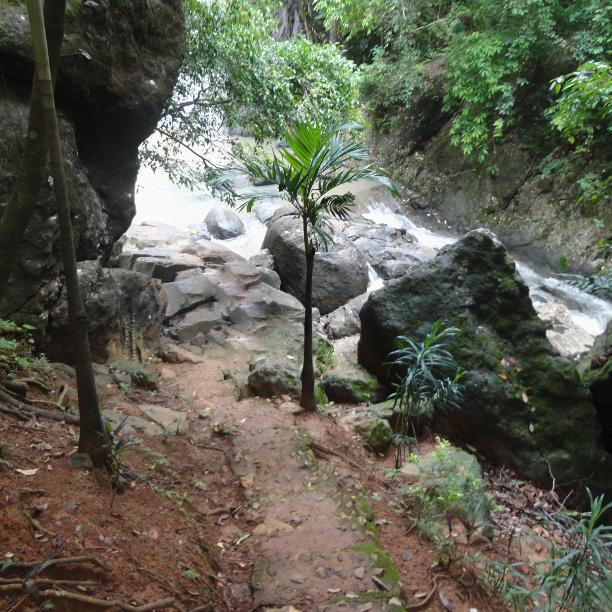

In [9]:
img = np.float32(PIL.Image.open('images/ariver.jpg'))
showarray(img)

Running the next code cell starts the detail generation process. You may see how new patterns start to form, iteration by iteration, octave by octave.

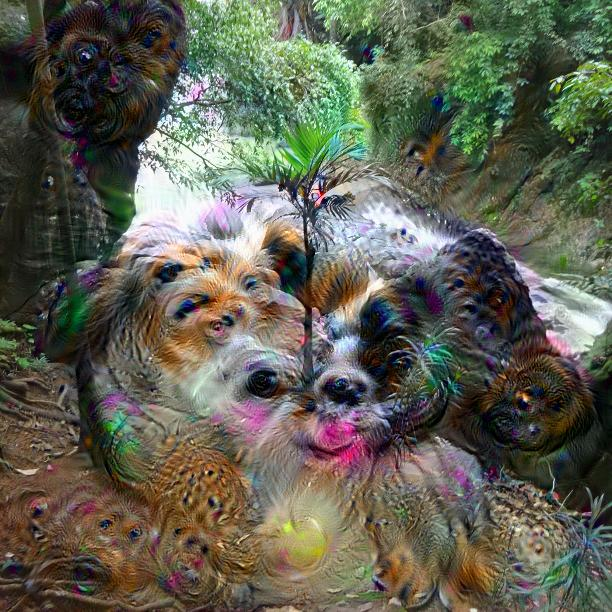

7 5 pool5 (612, 612, 3)


In [10]:
# may16.caffemodel
_=deepdream(net, img, iter_n=6, octave_n=8)

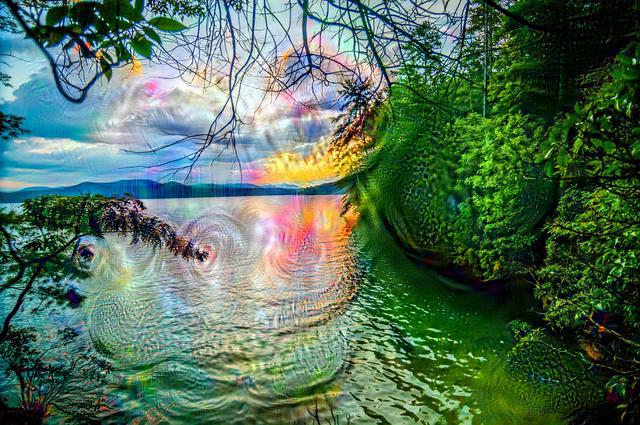

7 3 pool5 (425, 640, 3)


In [10]:
#  jcaffe.caffemodel
_=deepdream(net, img, iter_n=4, octave_n=8)

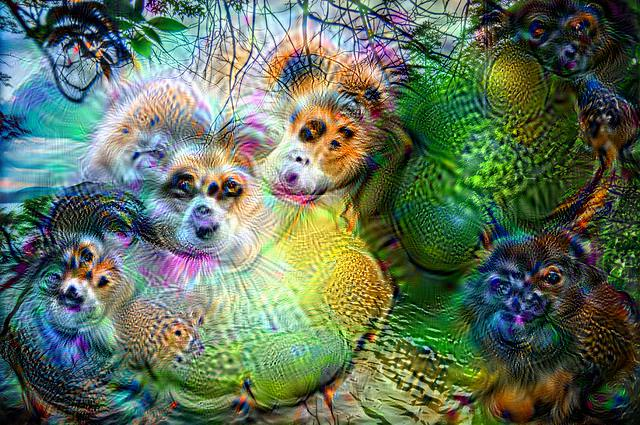

7 24 pool5 (425, 640, 3)


In [12]:
# .may16.caffemodel
_=deepdream(net, _, iter_n=25, octave_n=8)

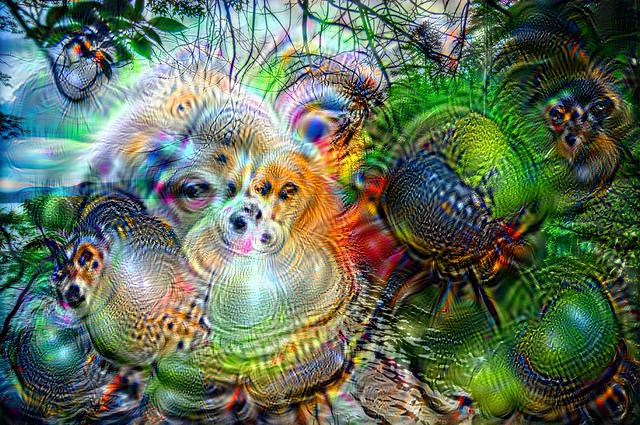

7 24 pool5 (425, 640, 3)


In [11]:
# jcafffe.caffemodel
_=deepdream(net, _, iter_n=25, octave_n=8)

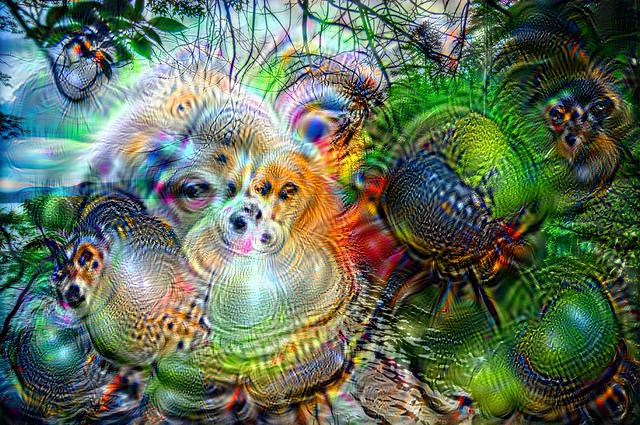

7 24 pool5 (425, 640, 3)


In [11]:
# jcafffe.caffemodel
_=deepdream(net, _, iter_n=25, octave_n=8)

The complexity of the details generated depends on which layer's activations we try to maximize. Higher layers produce complex features, while lower ones enhance edges and textures, giving the image an impressionist feeling:

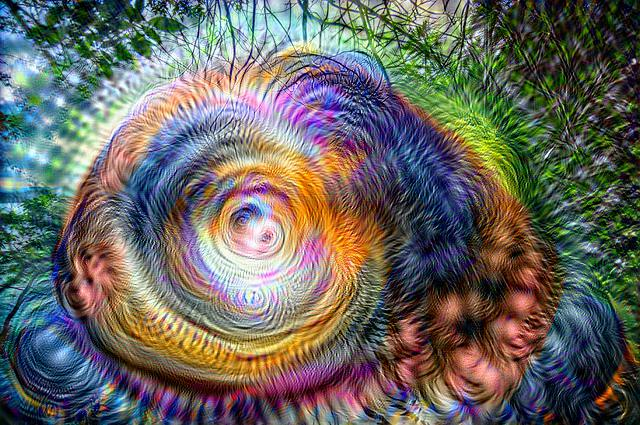

7 29 conv5 (425, 640, 3)


In [12]:
_=deepdream(net, _, iter_n=30, octave_n=8, end='conv5')

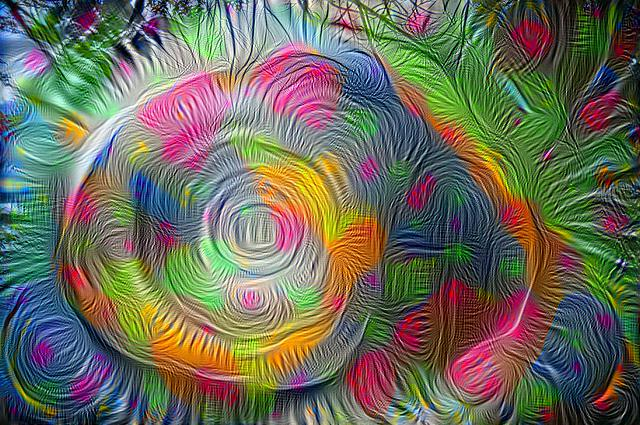

7 29 pool2 (425, 640, 3)


In [13]:
_=deepdream(net, _, iter_n=30, octave_n=8, end='pool2')

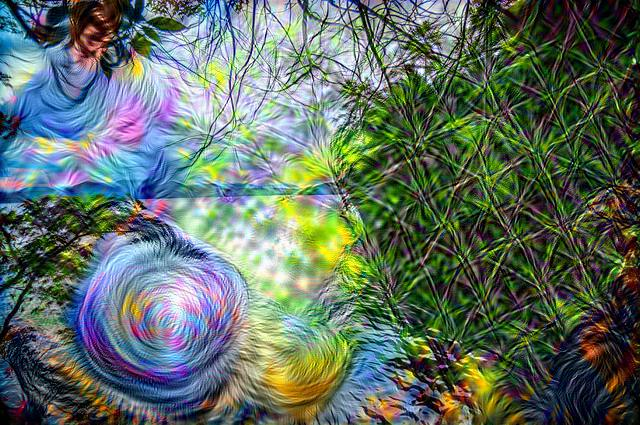

7 29 conv5 (425, 640, 3)


In [14]:
_=deepdream(net, img, iter_n=30, octave_n=8, end='conv5')

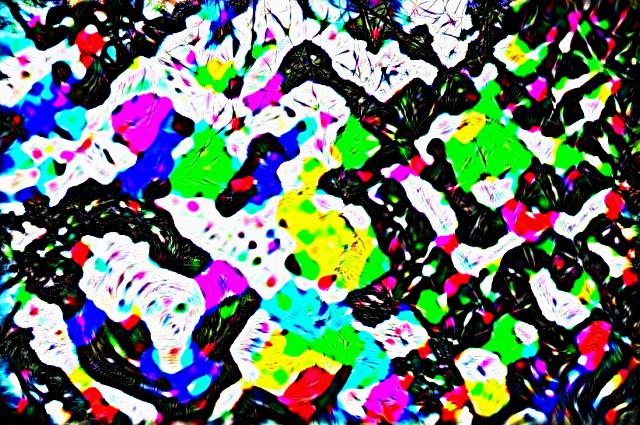

7 29 pool1 (425, 640, 3)


In [15]:
_=deepdream(net, _, iter_n=30, octave_n=8, end='pool1')

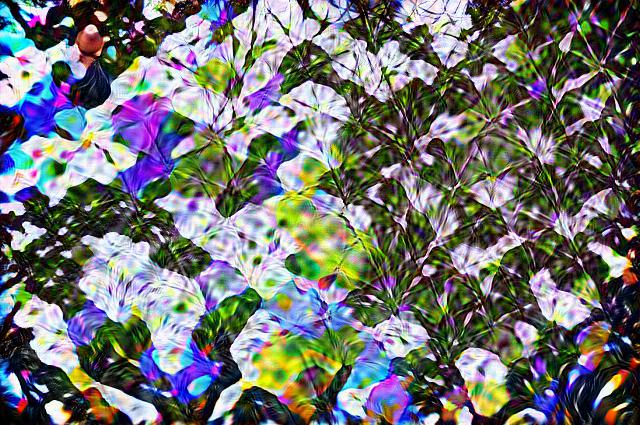

7 29 conv5 (425, 640, 3)


In [20]:
_=deepdream(net, _, iter_n=30, octave_n=8, clip='pool1', end='conv5')

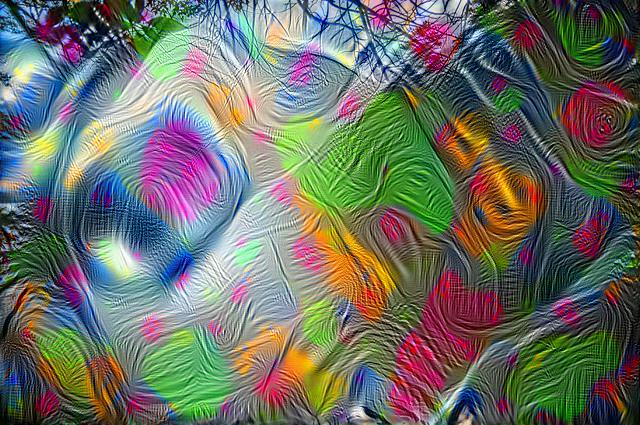

7 29 pool2 (425, 640, 3)


In [22]:
_=deepdream(net, _, iter_n=30, octave_n=8, clip='conv5', end='pool2')

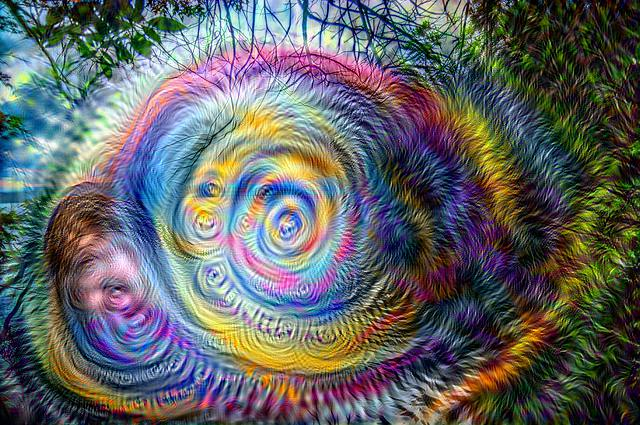

8 29 conv5 (425, 640, 3)


In [13]:
_=deepdream(net, img, iter_n=30, octave_n=9, clip='pool1', end='conv5')

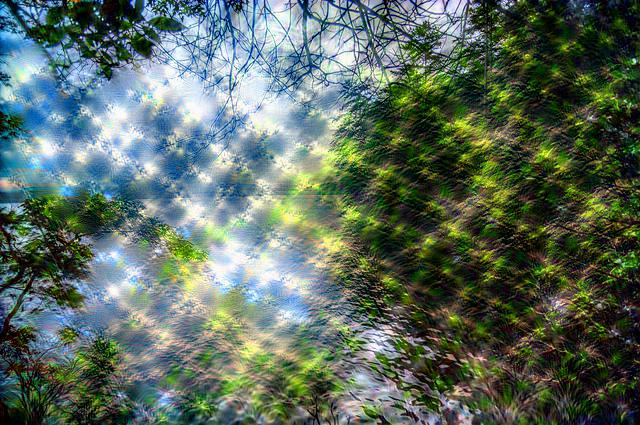

7 29 conv5 (425, 640, 3)


In [14]:
_=deepdream(net, img, iter_n=30, octave_n=8, clip='pool5', end='conv5')

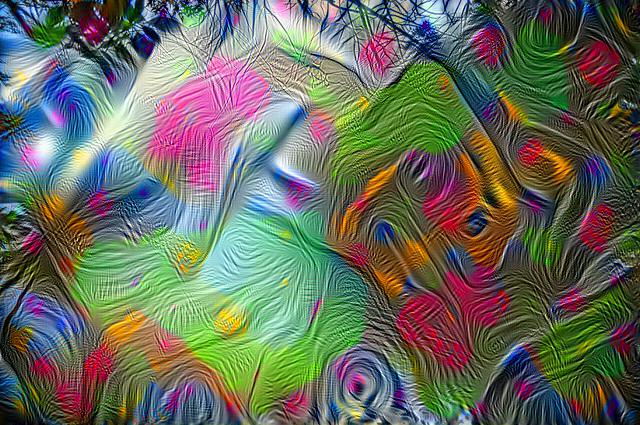

7 29 pool2 (425, 640, 3)


In [16]:
_=deepdream(net, _, step_size=1.55, iter_n=30, octave_n=8, clip='pool1', end='pool2')

We encourage readers to experiment with layer selection to see how it affects the results. Execute the next code cell to see the list of different layers. You can modify the `make_step` function to make it follow some different objective, say to select a subset of activations to maximize, or to maximize multiple layers at once. There is a huge design space to explore!

In [14]:
net.blobs.keys()

['data',
 'conv1',
 'pool1',
 'norm1',
 'conv2',
 'pool2',
 'norm2',
 'conv3',
 'conv4',
 'conv5',
 'pool5',
 'fc6',
 'fc7',
 'fc8_ft',
 'prob']

What if we feed the `deepdream` function its own output, after applying a little zoom to it? It turns out that this leads to an endless stream of impressions of the things that the network saw during training. Some patterns fire more often than others, suggestive of basins of attraction.

We will start the process from the same sky image as above, but after some iteration the original image becomes irrelevant; even random noise can be used as the starting point.

In [22]:
!mkdir framesplaces365
frame = img
frame_i = 0

mkdir: cannot create directory ‘framesplaces365’: File exists


In [23]:
h, w = frame.shape[:2]
s = 0.02 # scale coefficient
for i in xrange(100):
    frame = deepdream(net, frame)
    PIL.Image.fromarray(np.uint8(frame)).save("framesplaces365/bFract%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1

KeyboardInterrupt: 

Be careful running the code above, it can bring you into very strange realms!

In [ ]:
Image(filename='/notebooks/framesplaces365/0022.jpg')

In [ ]:
Image(filename='/notebooks/framesplaces365/0052.jpg')